In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score, 
    balanced_accuracy_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
if 'Diabetes_binary' not in df.columns and 'Diabetes' in df.columns:
    df['Diabetes_binary'] = df['Diabetes'].apply(lambda x: 0 if x == 0 else 1)
df = df.drop_duplicates().reset_index(drop=True)
df = df[(df['BMI'] >= 12) & (df['BMI'] <= 80)]

selected_features = ['GenHlth', 'BMI', 'Age', 'HighBP', 'HighChol', 'CholCheck',
                    'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                    'DiffWalk', 'Sex']
selected_features = [f for f in selected_features if f in df.columns]
X, y = df[selected_features], df['Diabetes_binary'].astype(int)

df.info()

2025-12-03 18:52:03.063407: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 18:52:03.071967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764762723.082214   10834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764762723.085458   10834 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764762723.093226   10834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<class 'pandas.core.frame.DataFrame'>
Index: 68987 entries, 0 to 69056
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       68987 non-null  float64
 1   HighBP                68987 non-null  float64
 2   HighChol              68987 non-null  float64
 3   CholCheck             68987 non-null  float64
 4   BMI                   68987 non-null  float64
 5   Smoker                68987 non-null  float64
 6   Stroke                68987 non-null  float64
 7   HeartDiseaseorAttack  68987 non-null  float64
 8   PhysActivity          68987 non-null  float64
 9   Fruits                68987 non-null  float64
 10  Veggies               68987 non-null  float64
 11  HvyAlcoholConsump     68987 non-null  float64
 12  AnyHealthcare         68987 non-null  float64
 13  NoDocbcCost           68987 non-null  float64
 14  GenHlth               68987 non-null  float64
 15  MentHlth              68

In [2]:
# Разделение
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Данные: train={X_train_scaled.shape}, val={X_val_scaled.shape}, test={X_test_scaled.shape}")

Данные: train=(48317, 13), val=(10321, 13), test=(10349, 13)


Данные: train=(48317, 13), val=(10321, 13), test=(10349, 13)
Epoch 1/180
471/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - auc: 0.7149 - auc_pr: 0.6917 - loss: 0.7379
Epoch 1: val_auc_pr improved from None to 0.76166, saving model to diabetes_nn_best.keras
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6938 - auc: 0.7410 - auc_pr: 0.7195 - loss: 0.6935 - val_accuracy: 0.7162 - val_auc: 0.7743 - val_auc_pr: 0.7617 - val_loss: 0.6379 - learning_rate: 7.0000e-04
Epoch 2/180
458/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7084 - auc: 0.7650 - auc_pr: 0.7502 - loss: 0.6507
Epoch 2: val_auc_pr did not improve from 0.76166
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7099 - auc: 0.7665 - auc_pr: 0.7518 - loss: 0.6459 - val_accuracy: 0.7132 - val_auc: 0.7733 - val_auc_pr: 0.7611 - val_loss: 0.6232 - learning_rate: 7.0000e-04
Epoch 3/180
455/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7147 - auc: 0.7706 - auc_pr: 0.7574 - loss: 0.6281
Epoch 3: val_auc

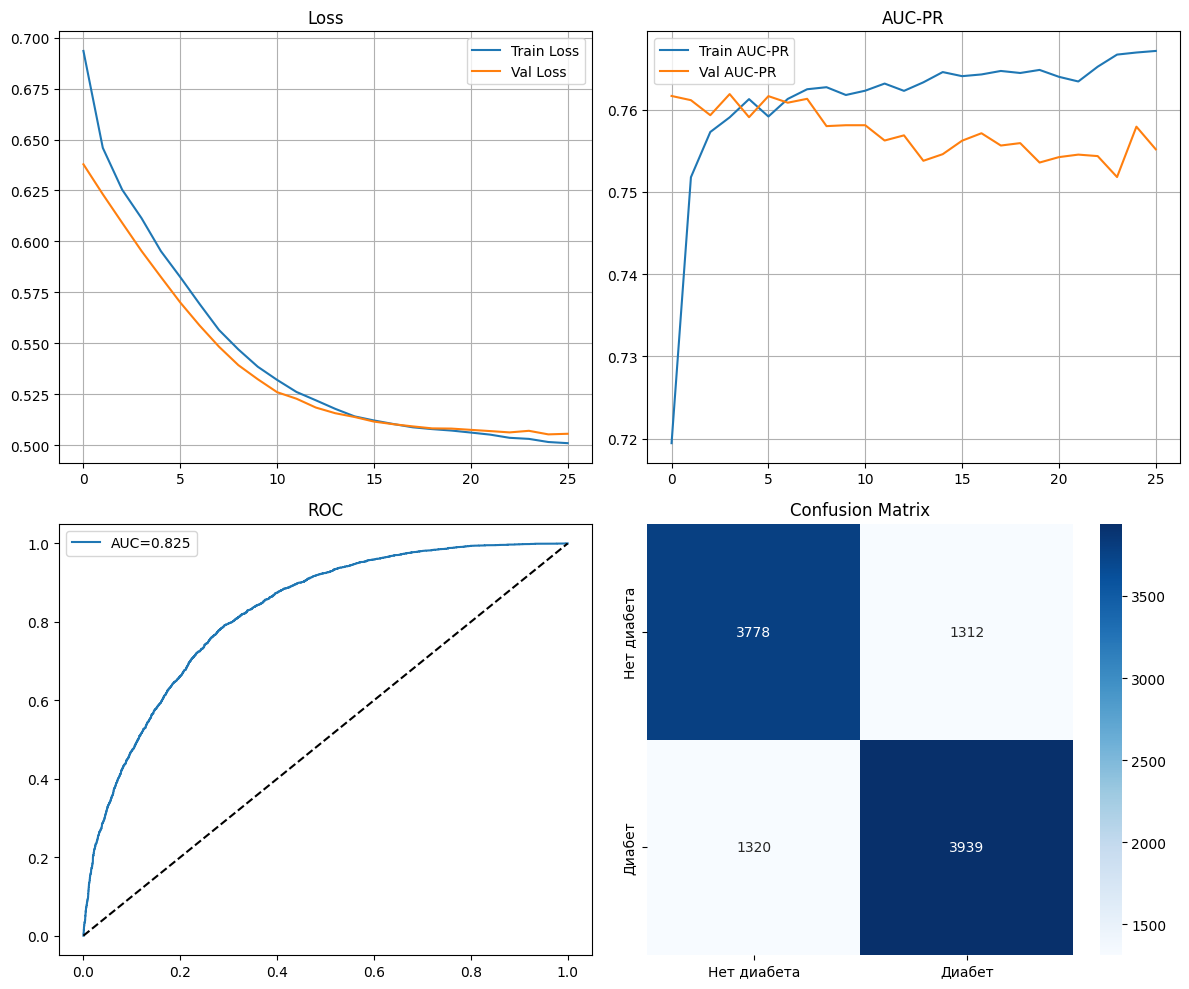


Модель сохранена: 'diabetes_nn_final.keras'


In [55]:
# Взвешенная BCE loss 
def weighted_bce(pos_weight=0.92):  
    def wghtd_bce(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        weights = y_true * (pos_weight - 1.0) + 1.0
        return tf.reduce_mean(bce * weights)
    return wghtd_bce

# 4. МОДЕЛЬ (усиленная архитектура)
def create_model(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(1.5e-4)),
        BatchNormalization(), Dropout(0.22),
        
        Dense(128, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(1.5e-4)),
        BatchNormalization(), Dropout(0.28),
        
        Dense(64, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(1.5e-4)),
        BatchNormalization(), Dropout(0.18),
        
        Dense(32, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(2e-4)),
        Dropout(0.12),
        
        Dense(1, activation=None)  # логиты
    ])
    
    loss_fn = weighted_bce(pos_weight=0.92)
    model.compile(
        optimizer=Adam(learning_rate=7e-4),
        loss=loss_fn,
        metrics=['accuracy', AUC(name='auc'), AUC(name='auc_pr', curve='PR')]
    )
    return model

# ГЛАВНАЯ ФУНКЦИЯ: подбор порога по МИНИМУМУ разницы recall_0 и recall_1
def find_optimal_threshold(model, X_val, y_val, target_recall_0=0.70):
    val_logits = model.predict(X_val, verbose=0).flatten()
    val_proba = tf.nn.sigmoid(val_logits).numpy()
    
    thresholds = np.arange(0.42, 0.62, 0.005)  # Точный поиск
    best_thresh, best_diff = 0.5, float('inf')
    
    for thresh in thresholds:
        y_pred = (val_proba > thresh).astype(int)
        recall_0 = recall_score(y_val, y_pred, pos_label=0, zero_division=0)
        recall_1 = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        
        # Цель: recall_0 >= 0.70 И минимальная разница между recall
        if recall_0 >= target_recall_0:
            diff = abs(recall_0 - recall_1)
            if diff < best_diff:
                best_diff = diff
                best_thresh = thresh
    
    print(f"Оптимальный порог: {best_thresh:.3f} (recall_0={recall_score(y_val, (val_proba>best_thresh).astype(int), pos_label=0):.4f})")
    return best_thresh

# Обучение
model = create_model(X_train_scaled.shape[1])

callbacks = [
    EarlyStopping(monitor='val_auc_pr', patience=22, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc_pr', factor=0.65, patience=10, min_lr=3e-7, verbose=1),
    ModelCheckpoint('diabetes_nn_best.keras', monitor='val_auc_pr', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=180,
    batch_size=100,  
    callbacks=callbacks,
    verbose=1
)

# Подбор порога и тестирование
best_thresh = find_optimal_threshold(model, X_val_scaled, y_val)
test_logits = model.predict(X_test_scaled, verbose=0).flatten()
test_proba = tf.nn.sigmoid(test_logits).numpy()
test_pred = (test_proba > best_thresh).astype(int)

# Метрики
results = {
    'threshold': best_thresh,
    'precision': precision_score(y_test, test_pred),
    'recall_0': recall_score(y_test, test_pred, pos_label=0),
    'recall_1': recall_score(y_test, test_pred, pos_label=1),
    'f1': f1_score(y_test, test_pred),
    'auc_roc': roc_auc_score(y_test, test_proba),
    'balanced_acc': balanced_accuracy_score(y_test, test_pred)
}
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
results['specificity'] = tn / (tn + fp)

# Вывод результатов
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ")
print("="*70)
print(f"Recall класс 0 (Нет диабета):  {results['recall_0']:.4f}")
print(f"Recall класс 1 (Диабет):      {results['recall_1']:.4f}")
print(f"Precision:                    {results['precision']:.4f}")
print(f"F1-score:                     {results['f1']:.4f}")
print(f"AUC-ROC:                      {results['auc_roc']:.4f}")
print(f"Balanced Accuracy:            {results['balanced_acc']:.4f}")
print(f"Specificity:                  {results['specificity']:.4f}")
print(f"Порог:                        {best_thresh:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=['Нет диабета', 'Есть диабет'], digits=4))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0,0].plot(history.history['loss'], label='Train Loss')
axes[0,0].plot(history.history['val_loss'], label='Val Loss')
axes[0,0].set_title('Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(history.history['auc_pr'], label='Train AUC-PR')
axes[0,1].plot(history.history['val_auc_pr'], label='Val AUC-PR')
axes[0,1].set_title('AUC-PR'); axes[0,1].legend(); axes[0,1].grid()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
axes[1,0].plot(fpr, tpr, label=f'AUC={results["auc_roc"]:.3f}')
axes[1,0].plot([0,1],[0,1],'k--'); axes[1,0].set_title('ROC'); axes[1,0].legend()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
            xticklabels=['Нет диабета', 'Диабет'], yticklabels=['Нет диабета', 'Диабет'])
axes[1,1].set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

model.save('diabetes_nn_final.keras')
print("\nМодель сохранена: 'diabetes_nn_final.keras'")